In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [2]:
def whitening_matrix(cov, cutoff=0.01):
    evals, evecs = np.linalg.eig(cov)

    inv_evals = 1./np.sqrt(evals)
    inv_evals[evals<cutoff*evals.max()] = 0

    w_mat = np.dot(np.dot(evecs, np.diag(inv_evals)), evecs.T)
    
    return w_mat

def plot_sta(spike_triggered, twinx=True):
    def _normalise(x):
        return (x-x.min(0))/(x.max() - x.min())
    N = spike_triggered.shape[1]
    sta = spike_triggered[:, N/2-49:N/2-20].T
    sta_lines = plt.plot(_normalise(sta), ':', lw=2)
    plt.yticks([])
        
    plt.twinx()
    K = kernel[:30, 1:]
    kernel_lines = plt.plot(_normalise(K))
    plt.xlim(-10, 50)
    plt.yticks([])
    
    return sta_lines, kernel_lines

To validate the whitening method and, specifically, to show that it recovers the post-synaptic contribution to the LFP from a spike of a single neuron, we tested it on model LFP signal.

For simplicity, we test the method on LFP signals recorded using only two electrodes, but this approach can be extended to multi-electode arrays (Utah arrays). We model the contribution from a local population around the electrode, which decays with electrode distance from cell and remote population, whose contribution does not depend on space. 

The rationale for the assumption is that the probability of connections between neurons decays very fast in the close neighbourhood of the neuron, but for distances above 1 mm it stays at small and constant level. The size of the remote population is large (it covers much larger area that the local population within the radius of < 1 mm), so that it's contribution can be significant, even if single neurons contribute little. 

Alternatively, the contribution from far population can in-direct, i.e., mediated by common inputs or modulations of excitability rather than direct connections.

We generate spikes of local population with constant rate using Bernoulli process. To obtain the current sources in space and time we convolve it with the spatio-temporal LFP kernel (unitary LFP field). Then we add the current sources of the population which is modelled using Poisson process convolved with temporal LFP kernel (as discussed above, we assume that the contribution of the remote population does not vary in space). Finally, we obtain the LFP by a linear superposition of the sources using a mixture matrix (also called a lead matrix in the EEG literature). Note that for simplicity we assumed linear, homogeneous and ohmic medium, but it's possible to generalise to non-ohmic media.

In [3]:
npts = 1000000
N = 1000
rate = 0.1
n_electrodes = 2
kernel_tau = 5.
kernel_amplitudes = [1., 0.35]

In [4]:
spikes = 1. * (np.random.rand(npts, n_electrodes) > (1-rate))
kernel = np.exp(-np.arange(100)/kernel_tau)[:,None]
kernel = kernel * np.array(kernel_amplitudes[-1:0:-1] + kernel_amplitudes)[None, :]

In [5]:
from scipy import signal
lfp = signal.fftconvolve(spikes, kernel, 'same').T
population = 1 * np.random.poisson(N * rate, (npts, n_electrodes))
lfp += population.T

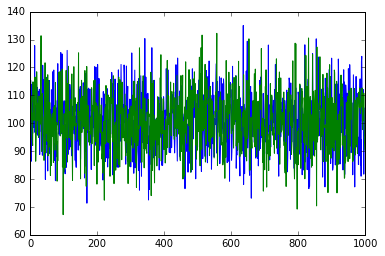

In [6]:
plt.plot(lfp[:2, :1000].T)

In [7]:
mixture_matrix = np.array([[1., 0.5], [0.5, 1]])
lfp = np.dot(mixture_matrix, lfp)

cov_mat = np.cov(lfp)

In [8]:
W = whitening_matrix(cov_mat)
W_opt = np.linalg.inv(mixture_matrix)

We estimate the LFP kernel using only the simulated LFP signal and spikes of local populaton. We calculated the spike-triggered LFP (st-LFP) the standard way (reverse correlation) and compare it with the original LFP kernel (which normally would not be available to the experimentalist). We found that the st-LFP is broader spatially than the kernel, i.e. its amplitude decays slower with distance than the model LFP kernel (Figure 1, left). This broadening is due to passive spread of electric field (the volume conduction), which is parametrised by the mixing (lead) matrix.

To recover the LFP kernel we might apply a spatial filtering. The optimal spatial filter is given by the inverse of the mixing matrix. Application of this filter to the st-LFP allows to recover the LFP kernel with the same spatial and temporal dependence (Figure 1, middle).

In practice, we do not know the mixing matrix, so we can not estimate the optimal unmixing filter. Therefore, we resort to the whitening technique, which allows to estimate the best filter directly from the data. To this end, we use a regularised pseudo-inverse of the ongoing LFP covariance matrix. We find that this technique allows to recover the LFP kernels, which are very close to the ones obtained using the optimal unmixing matrix, but also the original LFP kernel (Figure 1, right).

In [9]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')
whitened_stlfp = np.dot(W, spike_triggered)
optimal_stlfp = np.dot(W_opt, spike_triggered)


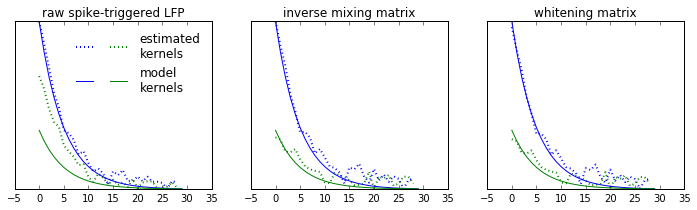

In [10]:
plt.figure(figsize=(12, 3))
ax1 = plt.subplot(131)
sta_lines, kernel_lines = plot_sta(spike_triggered)
lines = zip(sta_lines, kernel_lines)

plt.legend(lines[0] + lines[1], 
          ('\n', '\n', 'estimated\nkernels', 'model\nkernels'),
           columnspacing=0,
           ncol=2,
           frameon=False)
plt.title('raw spike-triggered LFP')
plt.subplot(132, sharex=ax1)
plot_sta(optimal_stlfp)
plt.title('inverse mixing matrix')
plt.subplot(133, sharex=ax1)
plot_sta(whitened_stlfp)
plt.title('whitening matrix')
plt.xlim(-5, 35)
plt.savefig('whitening_validation_fig1.pdf')

**Figure 1**. Comparsion between the modelled LFP kernel (thin line) and its estimation (dotted line) using three different methods: standard st-LFP (left), optimal un-mixing using known mixing matrix (middle), whitening (right). 

([<matplotlib.lines.Line2D at 0x7f778055ba50>,
  <matplotlib.lines.Line2D at 0x7f7780474810>])

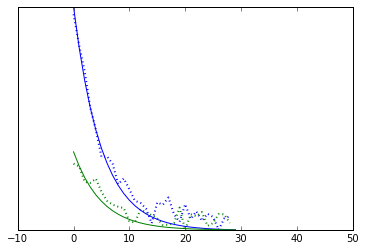

In [11]:


plot_sta(whitened_stlfp)

([<matplotlib.lines.Line2D at 0x7f778040d610>,
  <matplotlib.lines.Line2D at 0x7f778039bf50>])

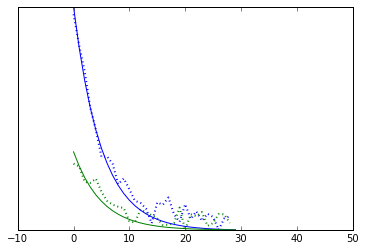

In [12]:

plot_sta(whitened_stlfp)

In [13]:
plt.legend?

## Co-modulated Poisson population

In [14]:
npts = 1000000
N = 100
mixture_matrix = np.array([[0.51, 0.49], [0.49, 0.51]])
#mixture_matrix = np.ones((2, 2))
rate = np.dot(mixture_matrix,  np.random.rand(2, npts)).T
spikes = 1. * (rate > 0.6)
population = np.random.poisson(N * rate)
print np.corrcoef(spikes.T)
print np.corrcoef(population.T)
print np.corrcoef(spikes[:, 0], population[:, 0])

[[ 1.          0.97074385]
 [ 0.97074385  1.        ]]
[[ 1.          0.89233545]
 [ 0.89233545  1.        ]]
[[ 1.          0.74123611]
 [ 0.74123611  1.        ]]


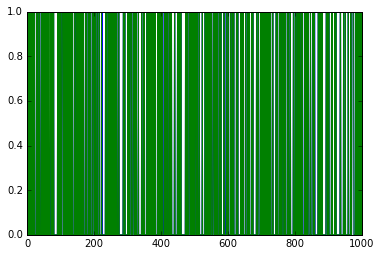

In [15]:
plt.plot(spikes[:1000, :])

In [16]:
spikes.sum(0)

array([ 320434.,  320490.])

In [17]:
kernel = np.exp(-np.arange(100)/10.)[:,None] * np.array([0.1, 1., 0.1])[None, :]

In [18]:
print kernel.shape

(100, 3)


LFP is modelled as a sum of pre-synaptic and post-synaptic contributions:

In [19]:

lfp = signal.fftconvolve(spikes, kernel, 'same').T + population.T
#lfp += N * (rate.T - rate.mean())

In [20]:
cov_mat = np.cov(lfp)
print cov_mat
W = whitening_matrix(cov_mat, 0.01)

[[ 468.89144589  418.60801948]
 [ 418.60801948  469.02455081]]


In [21]:
W

array([[ 0.08725604, -0.0536815 ],
       [-0.0536815 ,  0.08723897]])

In [22]:

spikes.sum(0)

array([ 320434.,  320490.])

In [23]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')
#spike_triggered /= signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')
whitened_stlfp = np.dot(W, spike_triggered)
#whitened_stlfp = np.dot(np.linalg.inv(mixture_matrix), spike_triggered)


([<matplotlib.lines.Line2D at 0x7f77800fadd0>,
  <matplotlib.lines.Line2D at 0x7f778008b990>])

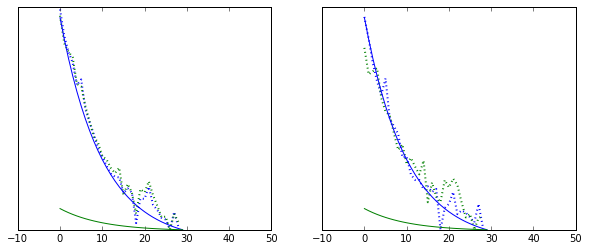

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_sta(spike_triggered)
plt.subplot(122)
plot_sta(whitened_stlfp)

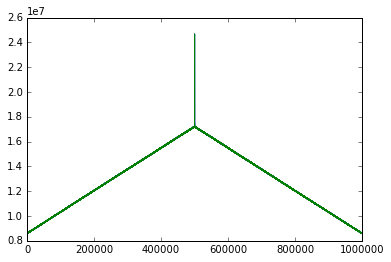

In [25]:

plt.plot(spike_triggered.T)

In [26]:
np.corrcoef(np.dot(W, lfp))

array([[  1.00000000e+00,  -4.46733764e-15],
       [ -4.46733764e-15,   1.00000000e+00]])

In [27]:
signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')

array([[ 160303.,  160303.,  160304., ...,  160133.,  160133.,  160132.],
       [ 160303.,  160303.,  160304., ...,  160133.,  160133.,  160132.]])

In [28]:
spikes.shape[0]

1000000